In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (14,11)
plt.rcParams["font.size"] = 20

 *   Take $S = \displaystyle \int_a^b  \displaystyle \frac{1}{\sqrt{1 + x^2}} \, dx$ </big>, where $a = 5$ and $b = 7$

 * Trapezoidal approximation $\displaystyle \int_{a}^{b} f(x) \approx S_D = \displaystyle \sum_{k = 1}^{N-1} \displaystyle \frac{f\left(a + k \,\tau\right)+ f\left(a + \left(k - 1\right) \tau\right) }{2}\,\,\tau$, where $ a + (N - 1)\tau = b$

In [9]:
# Compute analytically the value of S
def g(x):
    return np.log(abs(np.sqrt(x*x+1)+x))
a = 5
b = 7

print("Analytical solution of the integral S: ",g(b) - g(a))

Analytical solution of the integral S:  0.33168241978587654


In [11]:
# define integral function
def f(x):
    return (1 / np.sqrt(1+ x*x))

# define trapezoidal rule
def trapezoidal_approx(a, b, n, dx):
    result = (f(a) + f(b))/2.0
    for i in range(1, N):
        x = a + i*dx
        result +=f(x)
    result = result*dx
    return result

In [12]:
# Compute the integral using trapezoidal rule
a = 5
b = 7
N = 10000
dx = (b - a)/N

integration_error = np.abs(trapezoidal_approx(a,b,N,dx) - (g(b) - g(a)))
discretization_size = (b - a) / (N - 1)
print("Solution of the integral S using trapezoidal approximation: ",trapezoidal_approx(a,b,N,dx))
print("Integration error: ",integration_error)
print("Discretization size",discretization_size)

Solution of the integral S using trapezoidal approximation:  0.3316824198455942
Integration error:  5.971767524926008e-11
Discretization size 0.00020002000200020003


In [55]:
%%writefile integral.py

from mpi4py import MPI
import numpy as np

# define integral function
def f(x):
    return (1 / np.sqrt(1+ x*x))

# define trapezoidal rule
def trapezoidal_approx(left_endpt, right_endpt, n, dx):
    result = (f(left_endpt) + f(right_endpt))/2.0
    for i in range(1, N):
        x = left_endpt + i*dx
        result +=f(x)
    result = result*dx
    return result
    
a = 5
b = 7
N = 10000
total = 0

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
if rank ==0:
    start = MPI.Wtime()

dx = (b - a)/ N            #length of increment
N_per_rank = N // size         #number of intervals calculated by each process
if rank == size-1:
    N_per_rank = N -(N_per_rank * (size -1))
a_per_rank = a + rank*N_per_rank*dx
b_per_rank = a_per_rank + N_per_rank*dx

integral_per_rank = trapezoidal_approx(a_per_rank, b_per_rank, N_per_rank, dx) #Calculate each process' local integral using local endpoints

total = comm.reduce(integral_per_rank, op = MPI.SUM, root =0)

if rank ==0:
    end = MPI.Wtime()
    print((end-start))

Overwriting integral.py


In [56]:
exe_time = []
N_processes = np.arange(1,11)
for i in N_processes:
    add = !mpiexec -n {i} python integral.py
    exe_time.append(float(add[0]))
    print(f"Process {i} with time {add[0]}")

Process 1 with time 0.02887949999421835
Process 2 with time 0.030698199989274144
Process 3 with time 0.033376900013536215
Process 4 with time 0.036569699994288385
Process 5 with time 0.05554199998732656
Process 6 with time 0.05181739991530776
Process 7 with time 0.08342050004284829
Process 8 with time 0.09610830002930015
Process 9 with time 0.18341099994722754
Process 10 with time 0.20330259995535016


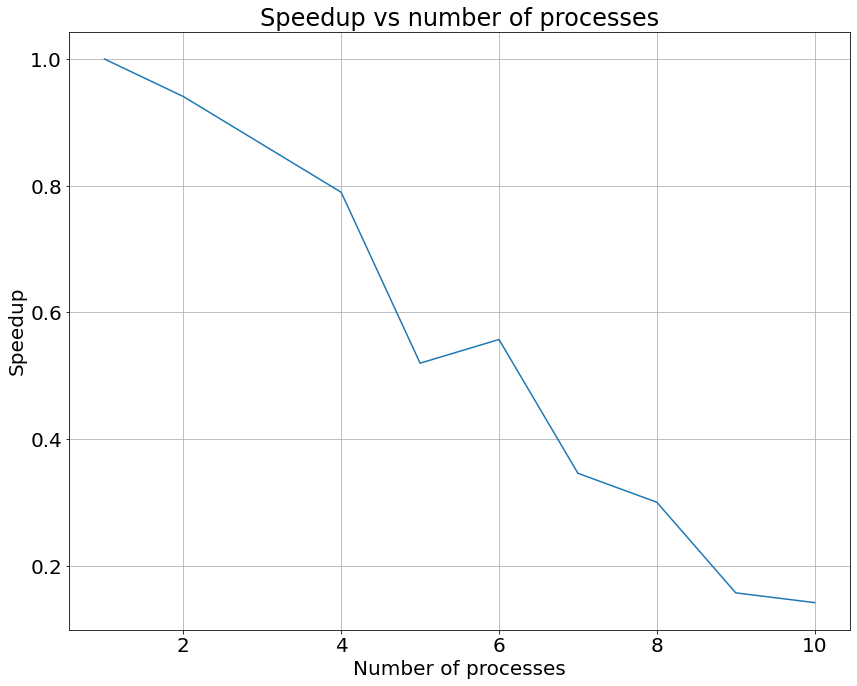

In [57]:
#Plot the speedup vs number of processors 
plt.plot(N_processes,  exe_time[0] / np.array(exe_time))
plt.title('Speedup vs number of processes')
plt.xlabel('Number of processes')
plt.ylabel('Speedup')
plt.grid(True)

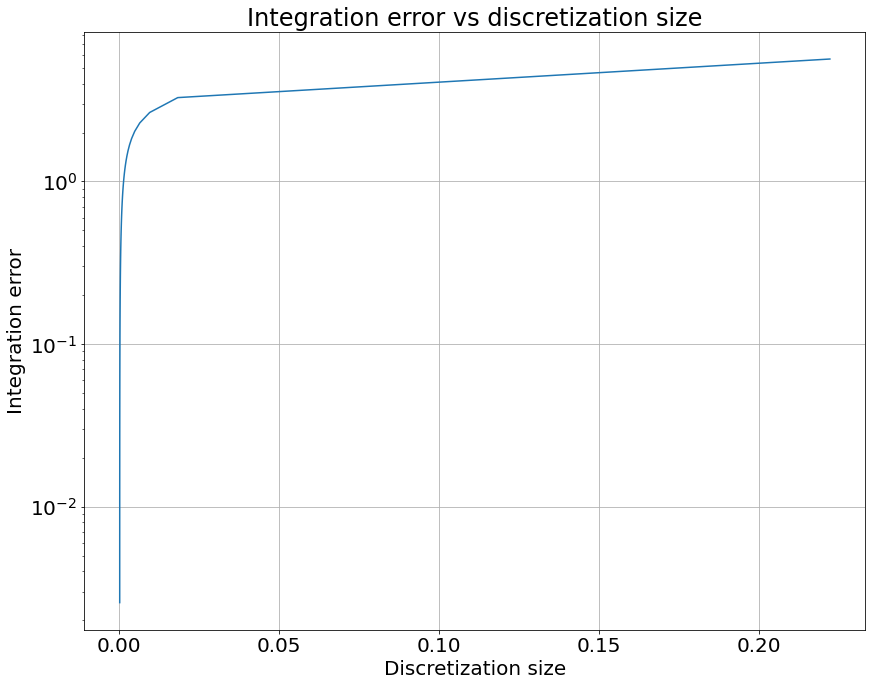

In [18]:
# Plot integration error vs the discretization size
a = 5
b = 7
N = 10000
integration_error =[]
discretization_size =[]
for i in range(10,N,100):
    dx = (b - a)/i
    integration_error.append(np.abs(trapezoidal_approx(a,b,i,dx) - (g(b) - g(a))))
    discretization_size.append((b - a) / (i - 1))

plt.semilogy(discretization_size,  integration_error)
plt.title('Integration error vs discretization size')
plt.xlabel('Discretization size')
plt.ylabel('Integration error')
plt.grid(True)